In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.optimizers import RMSprop

from decimal import Decimal

## Load the data we created in data_read_and_process.ipynb

In [2]:
X_train = np.load('../train_and_val/X_train.npy')
X_val = np.load('../train_and_val/X_val.npy')
y_train = np.load('../train_and_val/y_train.npy')
y_val = np.load('../train_and_val/y_val.npy')

## Build a Model

In [3]:
def lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4):
    """Generate a keras Sequential model of the form as described in Figure 16 of
    https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972"""
    model = Sequential()
    model.add(LSTM(n_lstm_nodes, return_sequences = True, input_shape = (16, 89,)))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_lstm_layers - 1):
        model.add(LSTM(n_lstm_nodes, return_sequences = True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_lstm_nodes // 2))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    for i in range(n_dense_layers - 1):
        model.add(Dense(n_lstm_nodes // 2))
        model.add(Dropout(0.6))
    model.add(Dense(89))
    model.add(Activation('sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'RMSProp')
    return model

## Custom Loss and Metrics

\begin{equation*}
bce\_loss = \frac{1}{N} (\sum_{i=1}^{N} y_i log(p(y_i)) + (1 - y_i) log(1 - p(y_i)))
\end{equation*}
\begin{equation*}
maestro\_loss = 2 * Harshness \lvert\frac{d_{true} - d_{pred}}{d_{true} + d{_{pred}}}\rvert
\end{equation*}
<br>
\begin{equation*}
total\_loss = MIN(2 * bce\_loss, bce\_loss + maestro\_loss)
\end{equation*}

where N = num_keys_piano, <b>Harshness</b> is a constant to be determined, and <b>d</b> gives the normalized duration. I'll call it the <b>Maestro Loss Function</b> since it pays special attention to the timing of the notes. It is usually composed of a Binary Cross Entropy Term with an additional term proportional to the relative error in duration between $d_{true}$ and $d_{pred}$. However, we limit the total_loss to be less than twice the bce_loss. We also define custom metrics, read the docstrings for their descriptions.

In [4]:
import keras.backend as K
import tensorflow as tf

def maestro_loss_wr(harshness): 
    """A loss function which, in addition to penalizing for misclassification on the 
    first n_keys_piano elements, includes a term proportional to the relative
    error in the prediction of the last element (which repesents the duration). 
    The proportionality constant is the 'harshness' of the maestro in regards to
    timing."""
    def maestro_loss(ytrue, ypred):
        # Standard binary cross-entropy
        bce_loss = - K.mean(ytrue[:, :-1] * K.log(ypred[:, :-1]) + (1 - ytrue[:, :-1]) * \
                     K.log(1 - ypred[:, :-1]))

        # Duration error term
        dur_loss = 2 * harshness * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / \
                                      (ytrue[:, -1] + ypred[:, -1] + K.epsilon())))
        
        if (dur_loss > bce_loss):   # Often times, ytrue[:, -1] elements will be zero
            return bce_loss * 2     # This may spike dur_loss. To control, I limit it
                                    # so that it never exceeds the bce_loss.
        return bce_loss + dur_loss
    
    return maestro_loss

def precision_mod(ytrue, ypred):
    """Just a modified precision excluding the last element (which is not a classification)"""

    true_positives = K.sum(K.round(ytrue[:, :-1] * ypred[:, :-1]))
    pred_positives = K.sum(K.round(ypred[:, :-1]))
    return true_positives / (pred_positives + K.epsilon())

def recall_mod(ytrue, ypred):
    """Just a modified recall excluding the last element (which is not a classification)"""

    true_positives = K.sum(K.round(ytrue[:, :-1] * ypred[:, :-1]))
    poss_positives = K.sum(ytrue[:, :-1])
    return true_positives / (poss_positives + K.epsilon())

def f1_score_mod(ytrue, ypred):
    """Just a modified f1_score excluding the last element (which is not a classification)"""

    precision = precision_mod(ytrue, ypred)
    recall = recall_mod(ytrue, ypred)   
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

def dur_error(ytrue, ypred):
    """A new metric that only gives information on the error in duration predictions"""
    
    return 2 * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / (ytrue[:, -1] + ypred[:, -1] + \
                                                         K.epsilon())))

def maestro_dur_loss_wr(harshness):
    """The second term of the maestro loss, based purely on error in duration predictions.
    To be used as a metric in order to decompose the loss components during analysis"""
    def maestro_dur_loss(ytrue, ypred):

        return 2 * harshness * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / \
                                      (ytrue[:, -1] + ypred[:, -1] + K.epsilon())))
    return maestro_dur_loss

In [5]:
def generate_cols_dict(history):
    """return a mapping of desired column names to the corresponding columns in the
    history dictionary (previously history.history where history is the return value
    of model.train)"""
    return {'maestro_loss': history['loss'], 'f1_score': history['f1_score_mod'], \
 'precision': history['precision_mod'], 'recall': history['recall_mod'], \
 'dur_error': history['dur_error'], 'dur_loss': history['maestro_dur_loss'], \
 'val_maestro_loss': history['val_loss'], 'val_f1_score': history['val_f1_score_mod'], \
 'val_precision': history['val_precision_mod'], 'val_recall': history['val_recall_mod'], \
 'val_dur_error': history['val_dur_error'], 'val_dur_loss': history['val_maestro_dur_loss']}

## Training

Let's begin with a similar model to [this paper](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972). To save time, let us use 2 LSTM layers and 1 Dense layer instead of (4 and 3 as in the paper) 

In [6]:
def train_lstm_model(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4, \
                     batch_size = 512, harshness = 0.05, lr = None, clipnorm = None, clipvalue = None, \
                     epochs = 150):
    """Train a model using the passed parameters, the data, and using the RMSprop optimizer. Write the
    best model as a .h5 and a .csv containing columns for the training and validation custom loss and
    metrics. Returns nothing."""
    model = lstm(n_lstm_layers = n_lstm_layers, n_dense_layers = n_dense_layers, \
                 n_lstm_nodes = n_lstm_nodes, dropout_rate = dropout_rate)

    if (lr or clipnorm or clipvalue):
        if (lr):          # It's required that the first argument to RMSprop is not None
            opt = RMSprop(lr = lr, clipnorm = clipnorm, clipvalue = clipvalue)
        elif (clipnorm):
            opt = RMSprop(clipnorm = clipnorm, clipvalue = clipvalue)
        else: # clipvalue
            opt = RMSprop(clipvalue = clipvalue)
    else:
        opt = RMSprop()   # TypeError when all are None, so do this instead
        
    model.compile(loss = maestro_loss_wr(harshness), optimizer = opt, metrics = [f1_score_mod, recall_mod, \
                                                precision_mod, dur_error, maestro_dur_loss_wr(harshness)])
    
    filename = 'best_maestro_model_{0}_{1}_{2}_{3}'.format(n_lstm_layers, n_dense_layers, n_lstm_nodes, \
                                                          str(dropout_rate).replace('.', 'pt'))
    if (lr):
        filename += '_lr_{}'.format('%.0e' % Decimal(lr))
    if (clipnorm):
        filename += '_cn_{}'.format(str(clipnorm).replace('.', 'pt'))     
    if (clipvalue):
        filename += '_cv_{}'.format(str(clipvalue).replace('.', 'pt'))
                                   
    mc = ModelCheckpoint('../models/' + filename + '.h5', monitor = 'val_loss', mode = 'min', \
                                                         save_best_only = True, verbose = 1)
                                   
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, \
                    validation_data = (X_val, y_val), verbose = 2, callbacks = [mc, TerminateOnNaN()])
    
    # In most preliminary tests model training has failed at some point when the loss becomes NaN during
    # validation
    if (len(history.history['val_loss']) < len(history.history['loss'])):  # a NaN during training
        for key, value in history.history.items():
            if (key[:3] == 'val'):          # pd.DataFrame requires value lengths to be equal
                value.append(np.nan)
                
    df = pd.DataFrame(generate_cols_dict(history.history))
    df.index.name = 'Epochs'
    df.to_csv('../model_data/' + filename + '.csv')

In [7]:
train_lstm_model()

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14822, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 149s - loss: 0.2169 - f1_score_mod: 0.0142 - recall_mod: 0.0208 - precision_mod: 0.0933 - dur_error: 0.9866 - maestro_dur_loss: 0.0493 - val_loss: 0.1482 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5802 - val_maestro_dur_loss: 0.0290
Epoch 2/150

Epoch 00002: val_loss improved from 0.14822 to 0.13735, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 138s - loss: 0.1598 - f1_score_mod: 0.0054 - recall_mod: 0.0027 - precision_mod: 0.3476 - dur_error: 0.7020 - maestro_dur_loss: 0.0351 - val_loss: 0.1374 - val_f1_score_mod: 0.0137 - val_recall_mod: 0.0070 - val_precision_mod: 0.6813 - val_dur_error: 0.4574 - val_maestro_dur_loss: 0.0229
Epoch 3/150

Epoch 00003: val_loss improved from 0.13735 to 0.13232, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 

Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10811
50/50 - 131s - loss: 0.1136 - f1_score_mod: 0.2653 - recall_mod: 0.1629 - precision_mod: 0.7232 - dur_error: 0.4448 - maestro_dur_loss: 0.0222 - val_loss: 0.1087 - val_f1_score_mod: 0.2944 - val_recall_mod: 0.1839 - val_precision_mod: 0.7412 - val_dur_error: 0.3894 - val_maestro_dur_loss: 0.0195
Epoch 23/150

Epoch 00023: val_loss improved from 0.10811 to 0.10599, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 131s - loss: 0.1122 - f1_score_mod: 0.2738 - recall_mod: 0.1692 - precision_mod: 0.7261 - dur_error: 0.4359 - maestro_dur_loss: 0.0218 - val_loss: 0.1060 - val_f1_score_mod: 0.2943 - val_recall_mod: 0.1828 - val_precision_mod: 0.7582 - val_dur_error: 0.3455 - val_maestro_dur_loss: 0.0173
Epoch 24/150

Epoch 00024: val_loss improved from 0.10599 to 0.10237, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 131s - loss: 0.1119 - f1_score_mod: 0.2792 - recall_mod: 0.1733 - preci

We'll refer to the above model as the 'base_model'. Looks like we get a NaN loss while the model was still improving. This seems to be case of exploding gradients. To combat this, we can try lowering the learning rate as suggested [here](https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons).

In [8]:
train_lstm_model(lr = 0.0005)

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14800, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 140s - loss: 0.2446 - f1_score_mod: 0.0299 - recall_mod: 0.0387 - precision_mod: 0.0858 - dur_error: 1.0080 - maestro_dur_loss: 0.0504 - val_loss: 0.1480 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5389 - val_maestro_dur_loss: 0.0269
Epoch 2/150

Epoch 00002: val_loss improved from 0.14800 to 0.14084, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 131s - loss: 0.1679 - f1_score_mod: 0.0054 - recall_mod: 0.0028 - precision_mod: 0.1578 - dur_error: 0.7188 - maestro_dur_loss: 0.0359 - val_loss: 0.1408 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4622 - val_maestro_dur_loss: 0.0231
Epoch 3/150

Epoch 00003: val_loss improved from 0.14084 to 0.13865, saving model to ../models/best_maestro_

Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10817
50/50 - 132s - loss: 0.1162 - f1_score_mod: 0.2287 - recall_mod: 0.1368 - precision_mod: 0.7081 - dur_error: 0.4292 - maestro_dur_loss: 0.0215 - val_loss: 0.1086 - val_f1_score_mod: 0.2292 - val_recall_mod: 0.1345 - val_precision_mod: 0.7795 - val_dur_error: 0.3310 - val_maestro_dur_loss: 0.0165
Epoch 23/150

Epoch 00023: val_loss improved from 0.10817 to 0.10614, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 132s - loss: 0.1160 - f1_score_mod: 0.2335 - recall_mod: 0.1401 - precision_mod: 0.7071 - dur_error: 0.4304 - maestro_dur_loss: 0.0215 - val_loss: 0.1061 - val_f1_score_mod: 0.2422 - val_recall_mod: 0.1437 - val_precision_mod: 0.7750 - val_dur_error: 0.2911 - val_maestro_dur_loss: 0.0146
Epoch 24/150

Epoch 00024: val_loss did not improve from 0.10614
50/50 - 131s - loss: 0.1153 - f1_score_mod: 0.2380 - recall_mod: 0.1433 - precision_mod: 0.7115 - dur_error: 0.4269 - maestro_dur_loss: 

Epoch 43/150

Epoch 00043: val_loss did not improve from 0.09911
50/50 - 132s - loss: 0.1043 - f1_score_mod: 0.3306 - recall_mod: 0.2135 - precision_mod: 0.7372 - dur_error: 0.3818 - maestro_dur_loss: 0.0191 - val_loss: 0.0998 - val_f1_score_mod: 0.3395 - val_recall_mod: 0.2200 - val_precision_mod: 0.7448 - val_dur_error: 0.2861 - val_maestro_dur_loss: 0.0143
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09911
50/50 - 130s - loss: 0.1040 - f1_score_mod: 0.3369 - recall_mod: 0.2188 - precision_mod: 0.7367 - dur_error: 0.3840 - maestro_dur_loss: 0.0192 - val_loss: 0.0993 - val_f1_score_mod: 0.3318 - val_recall_mod: 0.2117 - val_precision_mod: 0.7682 - val_dur_error: 0.2768 - val_maestro_dur_loss: 0.0138
Epoch 45/150

Epoch 00045: val_loss did not improve from 0.09911
50/50 - 131s - loss: 0.1033 - f1_score_mod: 0.3399 - recall_mod: 0.2210 - precision_mod: 0.7419 - dur_error: 0.3783 - maestro_dur_loss: 0.0189 - val_loss: 0.1033 - val_f1_score_mod: 0.3463 - val_recall_mod: 0.22

Epoch 65/150

Epoch 00065: val_loss improved from 0.09460 to 0.09453, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 132s - loss: 0.0930 - f1_score_mod: 0.4217 - recall_mod: 0.2941 - precision_mod: 0.7474 - dur_error: 0.3547 - maestro_dur_loss: 0.0177 - val_loss: 0.0945 - val_f1_score_mod: 0.4149 - val_recall_mod: 0.2908 - val_precision_mod: 0.7250 - val_dur_error: 0.2657 - val_maestro_dur_loss: 0.0133
Epoch 66/150

Epoch 00066: val_loss improved from 0.09453 to 0.09310, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 131s - loss: 0.0928 - f1_score_mod: 0.4228 - recall_mod: 0.2956 - precision_mod: 0.7445 - dur_error: 0.3559 - maestro_dur_loss: 0.0178 - val_loss: 0.0931 - val_f1_score_mod: 0.4203 - val_recall_mod: 0.2972 - val_precision_mod: 0.7185 - val_dur_error: 0.2448 - val_maestro_dur_loss: 0.0122
Epoch 67/150

Epoch 00067: val_loss did not improve from 0.09310
50/50 - 130s - loss: 0.0919 - f1_score_mod: 0.4280 - recall_m

Epoch 87/150
Batch 39: Invalid loss, terminating training
Batch 40: Invalid loss, terminating training
Batch 41: Invalid loss, terminating training
Batch 42: Invalid loss, terminating training
Batch 43: Invalid loss, terminating training
Batch 44: Invalid loss, terminating training
Batch 45: Invalid loss, terminating training
Batch 46: Invalid loss, terminating training
Batch 47: Invalid loss, terminating training
Batch 48: Invalid loss, terminating training
Batch 49: Invalid loss, terminating training

Epoch 00087: val_loss did not improve from 0.09219
50/50 - 131s - loss: nan - f1_score_mod: nan - recall_mod: nan - precision_mod: nan - dur_error: nan - maestro_dur_loss: nan - val_loss: nan - val_f1_score_mod: nan - val_recall_mod: nan - val_precision_mod: nan - val_dur_error: nan - val_maestro_dur_loss: nan


This model performed significantly better but was also still improving just before the NaN loss. We can also try [gradient clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/). There are two methods to accomplish this and they are controlled by the optional parameters to RMSProp (clipnorm and clipvalue). clipnorm limits the L2 norm of the gradients after each batch by rescaling them to be lower than the value set by clipnorm. clipvalue enforces a maximum/minimum value (equal to +/- clipvalue) for each gradient. In the linked blog post, reasonable values are given to be 1.0 for clipnorm and 0.5 for clipvalue. 

We could simply try these but it is better to get a look at the gradients for our base model to inform our decision. For this, we will need to run the base model again (using train_by_batch so I can call the following functions in between batches). Note that training by batch will slightly alter the results when compared to train (insert link). To inform the clipnorm choice, we simply need to calculate the L2-norm of the gradients after each batch. To inform the clipvalue choice, we will need to look at the minimum/maximum gradients (over the batch).

In [9]:
def get_gradient_norm_func(model):
    """Returns the gradient norm of the model averaged over all gradients of all layers"""

    grads = K.gradients(model.total_loss, model.trainable_weights)
    summed_squares = [K.sum(K.square(g)) for g in grads]
    norm = K.sqrt(sum(summed_squares))
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norm])

def get_gradient_stats_func(model):
    """Returns the gradient statistics of the model"""

    grads = K.gradients(model.total_loss, model.trainable_weights)
    means = [K.mean(g) for g in grads]
    minimums = [K.min(g) for g in grads]
    maximums = [K.max(g) for g in grads]
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means, minimums, maximums])

In [30]:
tf.compat.v1.disable_eager_execution()   # For some reason, I need to do this to have
                                         # access to total_loss. It's strange because 
                                         # model.run_eagerly = False both before and 
                                         # after running the command, as it should.
model = lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4)
harshness = 0.05
model.compile(loss = maestro_loss_wr(0.05), optimizer = RMSprop(), metrics = [f1_score_mod, dur_error, maestro_dur_loss_wr(0.05)])

get_gradient_norms = get_gradient_norm_func(model)
get_gradient_stats = get_gradient_stats_func(model)
norms_by_batch = []
stats_by_batch = []
batch_size = 512
epochs = 50
for i in range(epochs):
    print('Epoch {}:'.format(i + 1))
    for j in range(len(y_train) // batch_size):
        model.train_on_batch(X_train[j * batch_size: (j + 1) * batch_size], \
                             y_train[j * batch_size: (j + 1) * batch_size])
        
        # We just need to pass placeholder arrays of shape (?, window_size, 88),
        # (?, n_keys_piano + 1) and (n_keys_piano + 1)
        gradient_norms = get_gradient_norms([X_train[:2], y_train[:2], np.ones(2)])
        gradient_stats = get_gradient_stats([X_train[:2], y_train[:2], np.ones(2)])
        mean = np.mean(gradient_stats[0])
        minimum = min(gradient_stats[1])
        maximum = max(gradient_stats[2])
        print('batch {}'.format(j))
        norms_by_batch.append(gradient_norms[0])
        stats_by_batch.append([mean, minimum, maximum])
        
    model.train_on_batch(X_train[(j + 1) * batch_size:], y_train[(j + 1) * batch_size:])
    
    gradient_norms = get_gradient_norms([X_train[:2], y_train[:2], np.ones(2)])
    gradient_stats = get_gradient_stats([X_train[:2], y_train[:2], np.ones(2)])
    mean = np.mean(gradient_stats[0])
    minimum = min(gradient_stats[1])
    maximum = max(gradient_stats[2])
    norms_by_batch.append(gradient_norms[0])
    stats_by_batch.append([mean, minimum, maximum])

Epoch 1:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 2:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 3:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batc

batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 20:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 21:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
b

batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 39:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 40:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
b

In [32]:
# Combine the dataframes
df_norms = pd.DataFrame(norms_by_batch)
df_stats = pd.DataFrame(stats_by_batch)
df_grads = pd.concat([df_norms, df_stats], axis = 1).dropna()
df_grads.columns = ['norm', 'mean', 'min', 'max']
batches_per_epoch = 49
df_grads.index = pd.MultiIndex.from_tuples([((batch // batches_per_epoch) + 1, batch) \
                    for batch in range(1, len(df_grads) + 1)], names = ('Epoch', 'Batch'))
df_grads

norm      mean       min       max
Epoch Batch                                        
1     1      0.257828  0.000344 -0.017935  0.016901
      2      0.596167  0.000167 -0.038911  0.068653
      3      0.776338  0.000112 -0.091977  0.037675
      4      0.637393  0.000049 -0.092392  0.047412
      5      0.809789  0.000065 -0.044027  0.134970
...               ...       ...       ...       ...
50    2404   0.313298 -0.000011 -0.055644  0.031017
      2405   0.482061 -0.000052 -0.050685  0.064981
      2406   0.519350  0.000033 -0.079119  0.042278
      2407   0.511244 -0.000059 -0.047714  0.111103
      2408   0.254221 -0.000014 -0.042422  0.029684

[2408 rows x 4 columns]

In [33]:
# Save the data so we don't have to re-run the model
df_grads.to_csv('../model_data/gradients_2_1_512_0pt4.csv')

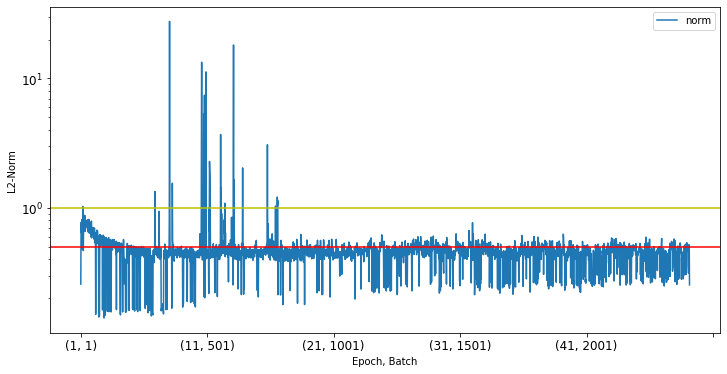

In [34]:
import matplotlib.pyplot as plt
df_grads = pd.read_csv('../model_data/gradients_2_1_512_0pt4.csv', index_col = [0, 1])
df_grads.plot(y = 'norm', figsize = (12, 6), logy = True, xlabel = 'Epoch, Batch', \
             ylabel = 'L2-Norm', fontsize = 12)
plt.axhline(1, color = 'y')
plt.axhline(0.5, color = 'r')

In the above plot (note the logscale on the y-axis), we have added a line corresponding to the suggested clipnorm value of 1.0. We can see that on several occasions in early training the L2-norm exceeds this value (sometimes by quite a lot!). It is possible that the norm for the final batch would have exploded. To get a better idea, one could re-run with a smaller batch size. However, there is no way to know how much we would have to decrease the batch size to see such an effect. Since lowering the batch size would also increase the run-time, we will halt the exploration here. Our plan is now to train models with clipnorm = 1.0 (line in <font color='yellow'>yellow</font>) and 0.5 (line in <font color='red'>red</font>). The latter should have an effect on the late-stage training.

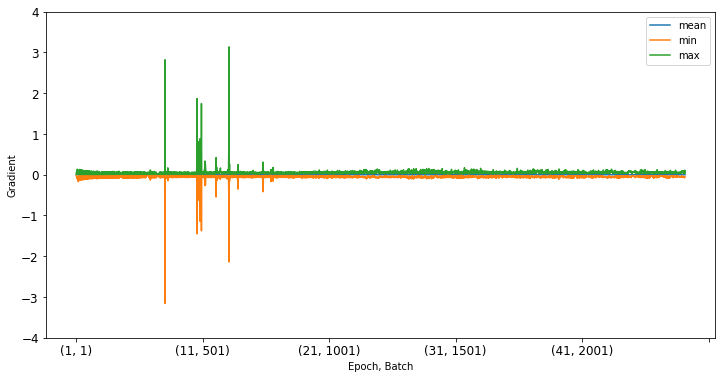

In [41]:
df_grads.plot(y = ['mean', 'min', 'max'], xlabel = 'Epoch, Batch', \
             ylabel = 'Gradient', figsize = (12, 6), fontsize = 12, ylim = [-4, 4])

In several occassions in early training some gradients are very large. The times at which these events happen seem to correlate with the times that the gradient norm is very high. We can see more detail by reduing the range in the y-axis.

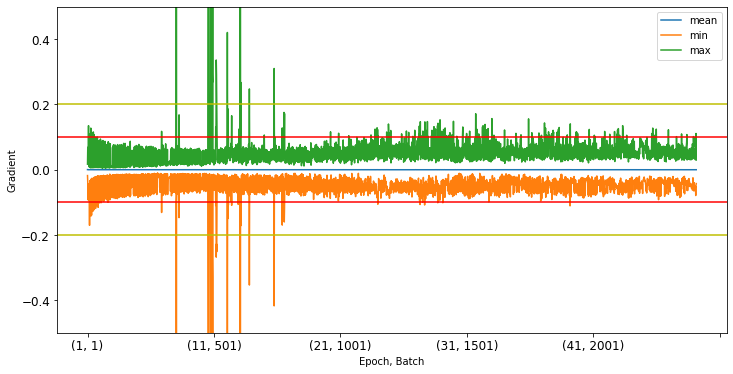

In [42]:
df_grads.plot(y = ['mean', 'min', 'max'], xlabel = 'Epoch, Batch', \
             ylabel = 'Gradient', figsize = (12, 6), fontsize = 12, ylim = [-.5, .5])
plt.axhline(0.2, color = 'y')
plt.axhline(-0.2, color = 'y')
plt.axhline(0.1, color = 'r')
plt.axhline(-0.1, color = 'r')

From this plot, we can see that the mean says near zero while the min and max (aside from the spikes in early training) stay at relatively small values (< 0.2). A clipvalue of 0.5 was used in the [blog post](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)). Perhaps such a value would delay the NaN failure in the final batch. However, from the plot, I think a clipvalue of 0.2 (line in <font color='yellow'>yellow</font>) is a better start. And then, we can reduce it to 0.1 (line in <font color='red'>red</font>) which should certainly affect the late training.

In [15]:
train_lstm_model(clipnorm = 1.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.14381, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25307/25307 - 132s - loss: 0.2169 - f1_score_mod: 0.0139 - recall_mod: 0.0210 - precision_mod: 0.1103 - dur_error: 0.9922 - maestro_dur_loss: 0.0496 - val_loss: 0.1438 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4486 - val_maestro_dur_loss: 0.0224
Epoch 2/150

Epoch 00002: val_loss improved from 0.14381 to 0.13693, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25307/25307 - 130s - loss: 0.1595 - f1_score_mod: 0.0059 - recall_mod: 0.0030 - precision_mod: 0.3522 - dur_error: 0.6959 - maestro_dur_loss: 0.0348 - val_loss: 0.1369 - val_f1_score_mod: 0.0278 - val_recall_mod: 0.0142 - val_precision_mod: 0.622

Epoch 21/150

Epoch 00021: val_loss improved from 0.10683 to 0.10681, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25307/25307 - 131s - loss: 0.1130 - f1_score_mod: 0.2742 - recall_mod: 0.1699 - precision_mod: 0.7189 - dur_error: 0.4447 - maestro_dur_loss: 0.0222 - val_loss: 0.1068 - val_f1_score_mod: 0.2982 - val_recall_mod: 0.1863 - val_precision_mod: 0.7508 - val_dur_error: 0.3632 - val_maestro_dur_loss: 0.0182
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10681
25307/25307 - 131s - loss: 0.1121 - f1_score_mod: 0.2796 - recall_mod: 0.1743 - precision_mod: 0.7180 - dur_error: 0.4418 - maestro_dur_loss: 0.0221 - val_loss: 0.1086 - val_f1_score_mod: 0.2886 - val_recall_mod: 0.1783 - val_precision_mod: 0.7678 - val_dur_error: 0.4076 - val_maestro_dur_loss: 0.0204
Epoch 23/150

Epoch 00023: val_loss improved from 0.10681 to 0.10161, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25307/25307 - 131s - loss: 0.1112 - f1_score_mod: 0

Epoch 42/150

Epoch 00042: val_loss improved from 0.09369 to 0.09301, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25307/25307 - 129s - loss: 0.0935 - f1_score_mod: 0.4236 - recall_mod: 0.2968 - precision_mod: 0.7439 - dur_error: 0.3753 - maestro_dur_loss: 0.0188 - val_loss: 0.0930 - val_f1_score_mod: 0.4187 - val_recall_mod: 0.2928 - val_precision_mod: 0.7357 - val_dur_error: 0.2530 - val_maestro_dur_loss: 0.0127
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.09301
25307/25307 - 132s - loss: 0.0925 - f1_score_mod: 0.4312 - recall_mod: 0.3036 - precision_mod: 0.7456 - dur_error: 0.3696 - maestro_dur_loss: 0.0185 - val_loss: 0.0963 - val_f1_score_mod: 0.4152 - val_recall_mod: 0.2879 - val_precision_mod: 0.7470 - val_dur_error: 0.3272 - val_maestro_dur_loss: 0.0164
Epoch 44/150
Batch 9: Invalid loss, terminating training
 5120/25307 - 21s - loss: nan - f1_score_mod: 0.4276 - recall_mod: 0.2998 - precision_mod: 0.7467 - dur_error: 0.3812 - maestro_dur_l

This model performed almost as well on the validation set as the model with half the default learning rate, in fewer epochs. However, it failed at a significantly higher training loss. Still, the clipnorm value seems to help in comparion to the base model. Let's now try with clipnorm = 0.5.

In [16]:
train_lstm_model(clipnorm = 0.5)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14471, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25307/25307 - 133s - loss: 0.2233 - f1_score_mod: 0.0145 - recall_mod: 0.0241 - precision_mod: 0.0862 - dur_error: 0.9982 - maestro_dur_loss: 0.0499 - val_loss: 0.1447 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4688 - val_maestro_dur_loss: 0.0234
Epoch 2/150

Epoch 00002: val_loss improved from 0.14471 to 0.13938, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25307/25307 - 131s - loss: 0.1617 - f1_score_mod: 0.0027 - recall_mod: 0.0014 - precision_mod: 0.2303 - dur_error: 0.7063 - maestro_dur_loss: 0.0353 - val_loss: 0.1394 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4489 - val_maestro_dur_loss: 0.0224
Epoch 3/150

Epoch 00003: val_loss did not impro

Epoch 21/150

Epoch 00021: val_loss improved from 0.10829 to 0.10600, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25307/25307 - 130s - loss: 0.1165 - f1_score_mod: 0.2411 - recall_mod: 0.1456 - precision_mod: 0.7134 - dur_error: 0.4571 - maestro_dur_loss: 0.0229 - val_loss: 0.1060 - val_f1_score_mod: 0.2649 - val_recall_mod: 0.1615 - val_precision_mod: 0.7450 - val_dur_error: 0.3079 - val_maestro_dur_loss: 0.0154
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10600
25307/25307 - 130s - loss: 0.1154 - f1_score_mod: 0.2490 - recall_mod: 0.1512 - precision_mod: 0.7151 - dur_error: 0.4509 - maestro_dur_loss: 0.0225 - val_loss: 0.1076 - val_f1_score_mod: 0.2688 - val_recall_mod: 0.1634 - val_precision_mod: 0.7706 - val_dur_error: 0.3461 - val_maestro_dur_loss: 0.0173
Epoch 23/150

Epoch 00023: val_loss improved from 0.10600 to 0.10521, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25307/25307 - 130s - loss: 0.1145 - f1_score_mod: 0

Epoch 42/150
Batch 12: Invalid loss, terminating training
 6656/25307 - 28s - loss: nan - f1_score_mod: 0.3954 - recall_mod: 0.2682 - precision_mod: 0.7548 - dur_error: 0.3901 - maestro_dur_loss: 0.0195


In [17]:
train_lstm_model(clipvalue = 0.2)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14871, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25307/25307 - 133s - loss: 0.2171 - f1_score_mod: 0.0151 - recall_mod: 0.0231 - precision_mod: 0.0964 - dur_error: 0.9845 - maestro_dur_loss: 0.0492 - val_loss: 0.1487 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6111 - val_maestro_dur_loss: 0.0306
Epoch 2/150

Epoch 00002: val_loss improved from 0.14871 to 0.13644, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25307/25307 - 130s - loss: 0.1577 - f1_score_mod: 0.0099 - recall_mod: 0.0050 - precision_mod: 0.4126 - dur_error: 0.6688 - maestro_dur_loss: 0.0334 - val_loss: 0.1364 - val_f1_score_mod: 0.0176 - val_recall_mod: 0.0089 - val_precision_mod: 0.7681 - val_dur_error: 0.4531 - val_maestro_dur_loss: 0.0227
Epoch 3/150

Epoch 00003: val_loss improved from 0.13644 to 

Epoch 22/150

Epoch 00022: val_loss improved from 0.10796 to 0.10488, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25307/25307 - 130s - loss: 0.1142 - f1_score_mod: 0.2631 - recall_mod: 0.1616 - precision_mod: 0.7172 - dur_error: 0.4516 - maestro_dur_loss: 0.0226 - val_loss: 0.1049 - val_f1_score_mod: 0.2857 - val_recall_mod: 0.1760 - val_precision_mod: 0.7692 - val_dur_error: 0.3043 - val_maestro_dur_loss: 0.0152
Epoch 23/150

Epoch 00023: val_loss improved from 0.10488 to 0.10386, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25307/25307 - 130s - loss: 0.1133 - f1_score_mod: 0.2706 - recall_mod: 0.1674 - precision_mod: 0.7150 - dur_error: 0.4448 - maestro_dur_loss: 0.0222 - val_loss: 0.1039 - val_f1_score_mod: 0.2930 - val_recall_mod: 0.1822 - val_precision_mod: 0.7515 - val_dur_error: 0.2998 - val_maestro_dur_loss: 0.0150
Epoch 24/150

Epoch 00024: val_loss did not improve from 0.10386
25307/25307 - 130s - loss: 0.1123 - f1_score_mod: 0

Epoch 43/150

Epoch 00043: val_loss improved from 0.09586 to 0.09386, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25307/25307 - 129s - loss: 0.0958 - f1_score_mod: 0.4051 - recall_mod: 0.2790 - precision_mod: 0.7431 - dur_error: 0.3780 - maestro_dur_loss: 0.0189 - val_loss: 0.0939 - val_f1_score_mod: 0.3869 - val_recall_mod: 0.2595 - val_precision_mod: 0.7649 - val_dur_error: 0.2606 - val_maestro_dur_loss: 0.0130
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09386
25307/25307 - 130s - loss: 0.0948 - f1_score_mod: 0.4139 - recall_mod: 0.2870 - precision_mod: 0.7447 - dur_error: 0.3787 - maestro_dur_loss: 0.0189 - val_loss: 0.1004 - val_f1_score_mod: 0.4134 - val_recall_mod: 0.2917 - val_precision_mod: 0.7133 - val_dur_error: 0.4009 - val_maestro_dur_loss: 0.0200
Epoch 45/150

Epoch 00045: val_loss did not improve from 0.09386
25307/25307 - 129s - loss: 0.0938 - f1_score_mod: 0.4185 - recall_mod: 0.2917 - precision_mod: 0.7430 - dur_error: 0.3714 - m

This yeilds the best performance yet aside from the run with the reduced learning rate, and it too fails at a significantly higher training loss.

In [18]:
train_lstm_model(clipvalue = 0.1)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14224, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25307/25307 - 133s - loss: 0.2188 - f1_score_mod: 0.0161 - recall_mod: 0.0273 - precision_mod: 0.1077 - dur_error: 0.9976 - maestro_dur_loss: 0.0499 - val_loss: 0.1422 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4639 - val_maestro_dur_loss: 0.0232
Epoch 2/150

Epoch 00002: val_loss improved from 0.14224 to 0.14177, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25307/25307 - 131s - loss: 0.1601 - f1_score_mod: 0.0033 - recall_mod: 0.0017 - precision_mod: 0.2592 - dur_error: 0.6883 - maestro_dur_loss: 0.0344 - val_loss: 0.1418 - val_f1_score_mod: 0.0016 - val_recall_mod: 8.1794e-04 - val_precision_mod: 0.7727 - val_dur_error: 0.5087 - val_maestro_dur_loss: 0.0254
Epoch 3/150

Epoch 00003: val_loss improved from 0.14177

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.11010
25307/25307 - 142s - loss: 0.1173 - f1_score_mod: 0.2330 - recall_mod: 0.1397 - precision_mod: 0.7134 - dur_error: 0.4586 - maestro_dur_loss: 0.0229 - val_loss: 0.1118 - val_f1_score_mod: 0.2327 - val_recall_mod: 0.1377 - val_precision_mod: 0.7615 - val_dur_error: 0.4033 - val_maestro_dur_loss: 0.0202
Epoch 22/150

Epoch 00022: val_loss improved from 0.11010 to 0.10953, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25307/25307 - 133s - loss: 0.1165 - f1_score_mod: 0.2395 - recall_mod: 0.1444 - precision_mod: 0.7149 - dur_error: 0.4559 - maestro_dur_loss: 0.0228 - val_loss: 0.1095 - val_f1_score_mod: 0.2342 - val_recall_mod: 0.1391 - val_precision_mod: 0.7529 - val_dur_error: 0.3539 - val_maestro_dur_loss: 0.0177
Epoch 23/150

Epoch 00023: val_loss improved from 0.10953 to 0.10745, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25307/25307 - 132s - loss: 0.1158 - f1_score_mod: 0

Epoch 42/150

Epoch 00042: val_loss did not improve from 0.09784
25307/25307 - 132s - loss: 0.1006 - f1_score_mod: 0.3685 - recall_mod: 0.2456 - precision_mod: 0.7415 - dur_error: 0.3928 - maestro_dur_loss: 0.0196 - val_loss: 0.1027 - val_f1_score_mod: 0.3782 - val_recall_mod: 0.2537 - val_precision_mod: 0.7452 - val_dur_error: 0.4005 - val_maestro_dur_loss: 0.0200
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.09784
25307/25307 - 131s - loss: 0.0994 - f1_score_mod: 0.3728 - recall_mod: 0.2494 - precision_mod: 0.7427 - dur_error: 0.3835 - maestro_dur_loss: 0.0192 - val_loss: 0.0985 - val_f1_score_mod: 0.3694 - val_recall_mod: 0.2439 - val_precision_mod: 0.7670 - val_dur_error: 0.3238 - val_maestro_dur_loss: 0.0162
Epoch 44/150

Epoch 00044: val_loss improved from 0.09784 to 0.09669, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25307/25307 - 131s - loss: 0.0987 - f1_score_mod: 0.3790 - recall_mod: 0.2544 - precision_mod: 0.7473 - dur_error: 0.3854 - m

Surprisingly, not as effective in delaying failure as clipvalue = 0.2. The best results were achieved with clipvalue = 0.2 and lr = 5e-4. Next, we will combine these settings. Check out visualize_performance.ipynb (Figures 1 and 2) for a comparison of the model training between the different approaches so far.

In [22]:
train_lstm_model(lr = 0.0005, clipvalue = 0.2)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15133, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 151s - loss: 0.2537 - f1_score_mod: 0.0309 - recall_mod: 0.0437 - precision_mod: 0.0805 - dur_error: 1.0674 - maestro_dur_loss: 0.0534 - val_loss: 0.1513 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6080 - val_maestro_dur_loss: 0.0304
Epoch 2/150

Epoch 00002: val_loss improved from 0.15133 to 0.14374, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 166s - loss: 0.1688 - f1_score_mod: 0.0053 - recall_mod: 0.0027 - precision_mod: 0.1348 - dur_error: 0.7262 - maestro_dur_loss: 0.0363 - val_loss: 0.1437 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5279 - val_maestro_dur_loss: 0.0264
Epoch 3/150

Epoch 00003: val_

Epoch 21/150

Epoch 00021: val_loss improved from 0.10778 to 0.10766, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 136s - loss: 0.1182 - f1_score_mod: 0.2136 - recall_mod: 0.1263 - precision_mod: 0.7008 - dur_error: 0.4418 - maestro_dur_loss: 0.0221 - val_loss: 0.1077 - val_f1_score_mod: 0.2371 - val_recall_mod: 0.1407 - val_precision_mod: 0.7636 - val_dur_error: 0.2991 - val_maestro_dur_loss: 0.0150
Epoch 22/150

Epoch 00022: val_loss improved from 0.10766 to 0.10730, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 154s - loss: 0.1177 - f1_score_mod: 0.2163 - recall_mod: 0.1282 - precision_mod: 0.6968 - dur_error: 0.4390 - maestro_dur_loss: 0.0219 - val_loss: 0.1073 - val_f1_score_mod: 0.2393 - val_recall_mod: 0.1421 - val_precision_mod: 0.7651 - val_dur_error: 0.2966 - val_maestro_dur_loss: 0.0148
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10730
25307/25307 - 155s - loss: 0.1170

Epoch 42/150

Epoch 00042: val_loss improved from 0.10048 to 0.10032, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 159s - loss: 0.1061 - f1_score_mod: 0.3124 - recall_mod: 0.1994 - precision_mod: 0.7293 - dur_error: 0.3911 - maestro_dur_loss: 0.0196 - val_loss: 0.1003 - val_f1_score_mod: 0.3262 - val_recall_mod: 0.2080 - val_precision_mod: 0.7616 - val_dur_error: 0.2829 - val_maestro_dur_loss: 0.0141
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.10032
25307/25307 - 161s - loss: 0.1058 - f1_score_mod: 0.3157 - recall_mod: 0.2020 - precision_mod: 0.7275 - dur_error: 0.3885 - maestro_dur_loss: 0.0194 - val_loss: 0.1022 - val_f1_score_mod: 0.3351 - val_recall_mod: 0.2150 - val_precision_mod: 0.7627 - val_dur_error: 0.3306 - val_maestro_dur_loss: 0.0165
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.10032
25307/25307 - 168s - loss: 0.1052 - f1_score_mod: 0.3207 - recall_mod: 0.2058 - precision_mod: 0.7299 - dur_error: 0

Epoch 63/150

Epoch 00063: val_loss did not improve from 0.09511
25307/25307 - 131s - loss: 0.0957 - f1_score_mod: 0.4027 - recall_mod: 0.2769 - precision_mod: 0.7409 - dur_error: 0.3622 - maestro_dur_loss: 0.0181 - val_loss: 0.0960 - val_f1_score_mod: 0.3992 - val_recall_mod: 0.2752 - val_precision_mod: 0.7302 - val_dur_error: 0.2853 - val_maestro_dur_loss: 0.0143
Epoch 64/150

Epoch 00064: val_loss improved from 0.09511 to 0.09444, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5
25307/25307 - 131s - loss: 0.0949 - f1_score_mod: 0.4080 - recall_mod: 0.2814 - precision_mod: 0.7448 - dur_error: 0.3623 - maestro_dur_loss: 0.0181 - val_loss: 0.0944 - val_f1_score_mod: 0.3999 - val_recall_mod: 0.2770 - val_precision_mod: 0.7213 - val_dur_error: 0.2591 - val_maestro_dur_loss: 0.0130
Epoch 65/150

Epoch 00065: val_loss did not improve from 0.09444
25307/25307 - 133s - loss: 0.0944 - f1_score_mod: 0.4111 - recall_mod: 0.2849 - precision_mod: 0.7407 - dur_error: 0

In [23]:
train_lstm_model(lr = 0.0005, clipvalue = 0.2, dropout_rate = 0.3)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14350, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cv_0pt2.h5
25307/25307 - 149s - loss: 0.2354 - f1_score_mod: 0.0213 - recall_mod: 0.0316 - precision_mod: 0.0808 - dur_error: 1.0024 - maestro_dur_loss: 0.0501 - val_loss: 0.1435 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4397 - val_maestro_dur_loss: 0.0220
Epoch 2/150

Epoch 00002: val_loss improved from 0.14350 to 0.14141, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cv_0pt2.h5
25307/25307 - 134s - loss: 0.1637 - f1_score_mod: 0.0024 - recall_mod: 0.0012 - precision_mod: 0.1509 - dur_error: 0.7021 - maestro_dur_loss: 0.0351 - val_loss: 0.1414 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4464 - val_maestro_dur_loss: 0.0223
Epoch 3/150

Epoch 00003: val_

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10963
25307/25307 - 131s - loss: 0.1167 - f1_score_mod: 0.2100 - recall_mod: 0.1236 - precision_mod: 0.7104 - dur_error: 0.4234 - maestro_dur_loss: 0.0212 - val_loss: 0.1172 - val_f1_score_mod: 0.2548 - val_recall_mod: 0.1561 - val_precision_mod: 0.7001 - val_dur_error: 0.4616 - val_maestro_dur_loss: 0.0231
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10963
25307/25307 - 131s - loss: 0.1160 - f1_score_mod: 0.2176 - recall_mod: 0.1290 - precision_mod: 0.7052 - dur_error: 0.4200 - maestro_dur_loss: 0.0210 - val_loss: 0.1145 - val_f1_score_mod: 0.2527 - val_recall_mod: 0.1539 - val_precision_mod: 0.7110 - val_dur_error: 0.4315 - val_maestro_dur_loss: 0.0216
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10963
25307/25307 - 130s - loss: 0.1146 - f1_score_mod: 0.2269 - recall_mod: 0.1354 - precision_mod: 0.7091 - dur_error: 0.4086 - maestro_dur_loss: 0.0204 - val_loss: 0.1111 - val_f1_score_mod: 0.2336 - va

Epoch 42/150

Epoch 00042: val_loss improved from 0.09896 to 0.09818, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cv_0pt2.h5
25307/25307 - 131s - loss: 0.1005 - f1_score_mod: 0.3508 - recall_mod: 0.2303 - precision_mod: 0.7395 - dur_error: 0.3549 - maestro_dur_loss: 0.0177 - val_loss: 0.0982 - val_f1_score_mod: 0.3538 - val_recall_mod: 0.2331 - val_precision_mod: 0.7377 - val_dur_error: 0.2710 - val_maestro_dur_loss: 0.0135
Epoch 43/150

Epoch 00043: val_loss improved from 0.09818 to 0.09783, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cv_0pt2.h5
25307/25307 - 131s - loss: 0.1001 - f1_score_mod: 0.3560 - recall_mod: 0.2343 - precision_mod: 0.7437 - dur_error: 0.3620 - maestro_dur_loss: 0.0181 - val_loss: 0.0978 - val_f1_score_mod: 0.3598 - val_recall_mod: 0.2388 - val_precision_mod: 0.7331 - val_dur_error: 0.2702 - val_maestro_dur_loss: 0.0135
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09783
25307/25307 - 131s - loss: 0.0993

Epoch 63/150

Epoch 00063: val_loss did not improve from 0.09381
25307/25307 - 132s - loss: 0.0866 - f1_score_mod: 0.4693 - recall_mod: 0.3409 - precision_mod: 0.7552 - dur_error: 0.3300 - maestro_dur_loss: 0.0165 - val_loss: 0.0989 - val_f1_score_mod: 0.4352 - val_recall_mod: 0.3166 - val_precision_mod: 0.6984 - val_dur_error: 0.3722 - val_maestro_dur_loss: 0.0186
Epoch 64/150

Epoch 00064: val_loss did not improve from 0.09381
25307/25307 - 133s - loss: 0.0855 - f1_score_mod: 0.4742 - recall_mod: 0.3457 - precision_mod: 0.7563 - dur_error: 0.3241 - maestro_dur_loss: 0.0162 - val_loss: 0.1004 - val_f1_score_mod: 0.4513 - val_recall_mod: 0.3417 - val_precision_mod: 0.6653 - val_dur_error: 0.3879 - val_maestro_dur_loss: 0.0194
Epoch 65/150

Epoch 00065: val_loss did not improve from 0.09381
25307/25307 - 132s - loss: 0.0848 - f1_score_mod: 0.4820 - recall_mod: 0.3541 - precision_mod: 0.7568 - dur_error: 0.3242 - maestro_dur_loss: 0.0162 - val_loss: 0.0944 - val_f1_score_mod: 0.4420 - va

Epoch 85/150

Epoch 00085: val_loss did not improve from 0.09312
25307/25307 - 131s - loss: 0.0696 - f1_score_mod: 0.6064 - recall_mod: 0.4960 - precision_mod: 0.7812 - dur_error: 0.3005 - maestro_dur_loss: 0.0150 - val_loss: 0.0934 - val_f1_score_mod: 0.4989 - val_recall_mod: 0.4018 - val_precision_mod: 0.6584 - val_dur_error: 0.2505 - val_maestro_dur_loss: 0.0125
Epoch 86/150

Epoch 00086: val_loss did not improve from 0.09312
25307/25307 - 132s - loss: 0.0689 - f1_score_mod: 0.6131 - recall_mod: 0.5048 - precision_mod: 0.7816 - dur_error: 0.2992 - maestro_dur_loss: 0.0150 - val_loss: 0.0963 - val_f1_score_mod: 0.5055 - val_recall_mod: 0.4144 - val_precision_mod: 0.6489 - val_dur_error: 0.3018 - val_maestro_dur_loss: 0.0151
Epoch 87/150

Epoch 00087: val_loss did not improve from 0.09312
25307/25307 - 132s - loss: 0.0684 - f1_score_mod: 0.6189 - recall_mod: 0.5116 - precision_mod: 0.7839 - dur_error: 0.3024 - maestro_dur_loss: 0.0151 - val_loss: 0.0940 - val_f1_score_mod: 0.5052 - va

It certainly does delay failure until the training loss is significantly lower. However, since dropout is designed to combat overfitting, lowering it increases overfitting causing the validation loss to remain relatively high. It now makes sense to increase dropout_rate since lowering it did not have a favorable effect.

In [25]:
train_lstm_model(lr = 0.0005, clipvalue = 0.2, dropout_rate = 0.5)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15223, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cv_0pt2.h5
25307/25307 - 140s - loss: 0.2556 - f1_score_mod: 0.0329 - recall_mod: 0.0428 - precision_mod: 0.0720 - dur_error: 1.0468 - maestro_dur_loss: 0.0523 - val_loss: 0.1522 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5185 - val_maestro_dur_loss: 0.0259
Epoch 2/150

Epoch 00002: val_loss improved from 0.15223 to 0.15132, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cv_0pt2.h5
25307/25307 - 133s - loss: 0.1740 - f1_score_mod: 0.0079 - recall_mod: 0.0041 - precision_mod: 0.1312 - dur_error: 0.7665 - maestro_dur_loss: 0.0383 - val_loss: 0.1513 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6486 - val_maestro_dur_loss: 0.0324
Epoch 3/150

Epoch 00003: val_

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.11108
25307/25307 - 132s - loss: 0.1222 - f1_score_mod: 0.1738 - recall_mod: 0.0997 - precision_mod: 0.6892 - dur_error: 0.4635 - maestro_dur_loss: 0.0232 - val_loss: 0.1155 - val_f1_score_mod: 0.2000 - val_recall_mod: 0.1158 - val_precision_mod: 0.7524 - val_dur_error: 0.4077 - val_maestro_dur_loss: 0.0204
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.11108
25307/25307 - 132s - loss: 0.1214 - f1_score_mod: 0.1785 - recall_mod: 0.1028 - precision_mod: 0.6880 - dur_error: 0.4582 - maestro_dur_loss: 0.0229 - val_loss: 0.1178 - val_f1_score_mod: 0.2114 - val_recall_mod: 0.1227 - val_precision_mod: 0.7680 - val_dur_error: 0.4658 - val_maestro_dur_loss: 0.0233
Epoch 23/150

Epoch 00023: val_loss improved from 0.11108 to 0.10981, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cv_0pt2.h5
25307/25307 - 132s - loss: 0.1206 - f1_score_mod: 0.1844 - recall_mod: 0.1065 - precision_mod: 0.6941 - dur_error: 0

Epoch 42/150

Epoch 00042: val_loss did not improve from 0.10295
25307/25307 - 132s - loss: 0.1119 - f1_score_mod: 0.2594 - recall_mod: 0.1583 - precision_mod: 0.7224 - dur_error: 0.4182 - maestro_dur_loss: 0.0209 - val_loss: 0.1053 - val_f1_score_mod: 0.2875 - val_recall_mod: 0.1779 - val_precision_mod: 0.7598 - val_dur_error: 0.3349 - val_maestro_dur_loss: 0.0167
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.10295
25307/25307 - 132s - loss: 0.1111 - f1_score_mod: 0.2630 - recall_mod: 0.1610 - precision_mod: 0.7227 - dur_error: 0.4085 - maestro_dur_loss: 0.0204 - val_loss: 0.1046 - val_f1_score_mod: 0.3074 - val_recall_mod: 0.1944 - val_precision_mod: 0.7404 - val_dur_error: 0.3239 - val_maestro_dur_loss: 0.0162
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.10295
25307/25307 - 133s - loss: 0.1111 - f1_score_mod: 0.2687 - recall_mod: 0.1654 - precision_mod: 0.7215 - dur_error: 0.4130 - maestro_dur_loss: 0.0206 - val_loss: 0.1055 - val_f1_score_mod: 0.3062 - va

Epoch 63/150

Epoch 00063: val_loss improved from 0.09740 to 0.09686, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cv_0pt2.h5
25307/25307 - 132s - loss: 0.1032 - f1_score_mod: 0.3378 - recall_mod: 0.2198 - precision_mod: 0.7345 - dur_error: 0.3856 - maestro_dur_loss: 0.0193 - val_loss: 0.0969 - val_f1_score_mod: 0.3603 - val_recall_mod: 0.2367 - val_precision_mod: 0.7566 - val_dur_error: 0.2545 - val_maestro_dur_loss: 0.0127
Epoch 64/150

Epoch 00064: val_loss did not improve from 0.09686
25307/25307 - 133s - loss: 0.1027 - f1_score_mod: 0.3408 - recall_mod: 0.2224 - precision_mod: 0.7330 - dur_error: 0.3864 - maestro_dur_loss: 0.0193 - val_loss: 0.0988 - val_f1_score_mod: 0.3641 - val_recall_mod: 0.2405 - val_precision_mod: 0.7519 - val_dur_error: 0.2925 - val_maestro_dur_loss: 0.0146
Epoch 65/150

Epoch 00065: val_loss did not improve from 0.09686
25307/25307 - 132s - loss: 0.1023 - f1_score_mod: 0.3453 - recall_mod: 0.2261 - precision_mod: 0.7347 - dur_error: 0

The training here does a better job of generalizing to the validation set (as expected) but causes an earlier failure (in terms of training loss). For a visual comparison of performance depending on the dropout_rate, see Figures 5 and 6 from visualize_performance.ipynb.

Our best performing model is ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cv_0pt2.h5. See the final section in visualize_performance.ipynb for an in-depth visual analysis of the performance of this model. We can also load this model and generate some music, and this is the task of ../webapp, which also provides a user interface for customization.

In [ ]:
train_lstm_model(lr = 0.0001, clipvalue = 0.2, epochs = 500)

Train on 25307 samples, validate on 10846 samples
Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.17353, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 162s - loss: 0.4134 - f1_score_mod: 0.0581 - recall_mod: 0.1424 - precision_mod: 0.0420 - dur_error: 1.2514 - maestro_dur_loss: 0.0626 - val_loss: 0.1735 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.7284 - val_maestro_dur_loss: 0.0364
Epoch 2/500

Epoch 00002: val_loss improved from 0.17353 to 0.15280, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 164s - loss: 0.2345 - f1_score_mod: 0.0437 - recall_mod: 0.0353 - precision_mod: 0.0620 - dur_error: 0.9727 - maestro_dur_loss: 0.0486 - val_loss: 0.1528 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5033 - val_maestro_dur_loss: 0.0252
Epoch 3/500

Epoch 00003: val_

Epoch 20/500

Epoch 00020: val_loss improved from 0.12708 to 0.12526, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 143s - loss: 0.1372 - f1_score_mod: 0.0562 - recall_mod: 0.0296 - precision_mod: 0.6006 - dur_error: 0.5121 - maestro_dur_loss: 0.0256 - val_loss: 0.1253 - val_f1_score_mod: 0.0499 - val_recall_mod: 0.0258 - val_precision_mod: 0.7697 - val_dur_error: 0.3825 - val_maestro_dur_loss: 0.0191
Epoch 21/500

Epoch 00021: val_loss improved from 0.12526 to 0.12377, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 133s - loss: 0.1365 - f1_score_mod: 0.0607 - recall_mod: 0.0320 - precision_mod: 0.5923 - dur_error: 0.5069 - maestro_dur_loss: 0.0253 - val_loss: 0.1238 - val_f1_score_mod: 0.0658 - val_recall_mod: 0.0345 - val_precision_mod: 0.7413 - val_dur_error: 0.3621 - val_maestro_dur_loss: 0.0181
Epoch 22/500

Epoch 00022: val_loss did not improve from 0.12377
25307/25307 - 132s - loss: 0.1355


Epoch 00040: val_loss did not improve from 0.11436
25307/25307 - 143s - loss: 0.1257 - f1_score_mod: 0.1244 - recall_mod: 0.0689 - precision_mod: 0.6582 - dur_error: 0.4390 - maestro_dur_loss: 0.0219 - val_loss: 0.1185 - val_f1_score_mod: 0.1647 - val_recall_mod: 0.0931 - val_precision_mod: 0.7284 - val_dur_error: 0.3786 - val_maestro_dur_loss: 0.0189
Epoch 41/500

Epoch 00041: val_loss did not improve from 0.11436
25307/25307 - 147s - loss: 0.1253 - f1_score_mod: 0.1245 - recall_mod: 0.0690 - precision_mod: 0.6566 - dur_error: 0.4345 - maestro_dur_loss: 0.0217 - val_loss: 0.1156 - val_f1_score_mod: 0.1643 - val_recall_mod: 0.0929 - val_precision_mod: 0.7380 - val_dur_error: 0.3301 - val_maestro_dur_loss: 0.0165
Epoch 42/500

Epoch 00042: val_loss did not improve from 0.11436
25307/25307 - 135s - loss: 0.1250 - f1_score_mod: 0.1286 - recall_mod: 0.0713 - precision_mod: 0.6706 - dur_error: 0.4348 - maestro_dur_loss: 0.0217 - val_loss: 0.1145 - val_f1_score_mod: 0.1462 - val_recall_mod:

Epoch 61/500

Epoch 00061: val_loss did not improve from 0.10957
25307/25307 - 144s - loss: 0.1199 - f1_score_mod: 0.1723 - recall_mod: 0.0987 - precision_mod: 0.6892 - dur_error: 0.4085 - maestro_dur_loss: 0.0204 - val_loss: 0.1112 - val_f1_score_mod: 0.1931 - val_recall_mod: 0.1108 - val_precision_mod: 0.7651 - val_dur_error: 0.3136 - val_maestro_dur_loss: 0.0157
Epoch 62/500

Epoch 00062: val_loss did not improve from 0.10957
25307/25307 - 144s - loss: 0.1195 - f1_score_mod: 0.1740 - recall_mod: 0.1000 - precision_mod: 0.6804 - dur_error: 0.4102 - maestro_dur_loss: 0.0205 - val_loss: 0.1158 - val_f1_score_mod: 0.2062 - val_recall_mod: 0.1201 - val_precision_mod: 0.7342 - val_dur_error: 0.4052 - val_maestro_dur_loss: 0.0203
Epoch 63/500

Epoch 00063: val_loss did not improve from 0.10957
25307/25307 - 144s - loss: 0.1194 - f1_score_mod: 0.1747 - recall_mod: 0.1004 - precision_mod: 0.6889 - dur_error: 0.4084 - maestro_dur_loss: 0.0204 - val_loss: 0.1114 - val_f1_score_mod: 0.1955 - va

Epoch 83/500

Epoch 00083: val_loss improved from 0.10639 to 0.10609, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 144s - loss: 0.1158 - f1_score_mod: 0.2092 - recall_mod: 0.1232 - precision_mod: 0.7019 - dur_error: 0.3925 - maestro_dur_loss: 0.0196 - val_loss: 0.1061 - val_f1_score_mod: 0.2359 - val_recall_mod: 0.1407 - val_precision_mod: 0.7460 - val_dur_error: 0.2636 - val_maestro_dur_loss: 0.0132
Epoch 84/500

Epoch 00084: val_loss did not improve from 0.10609
25307/25307 - 144s - loss: 0.1155 - f1_score_mod: 0.2091 - recall_mod: 0.1231 - precision_mod: 0.7045 - dur_error: 0.3901 - maestro_dur_loss: 0.0195 - val_loss: 0.1086 - val_f1_score_mod: 0.2469 - val_recall_mod: 0.1489 - val_precision_mod: 0.7271 - val_dur_error: 0.3117 - val_maestro_dur_loss: 0.0156
Epoch 85/500

Epoch 00085: val_loss improved from 0.10609 to 0.10578, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 146s - loss: 0.1155

Epoch 105/500

Epoch 00105: val_loss improved from 0.10370 to 0.10369, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 143s - loss: 0.1124 - f1_score_mod: 0.2425 - recall_mod: 0.1462 - precision_mod: 0.7171 - dur_error: 0.3798 - maestro_dur_loss: 0.0190 - val_loss: 0.1037 - val_f1_score_mod: 0.2738 - val_recall_mod: 0.1691 - val_precision_mod: 0.7267 - val_dur_error: 0.2589 - val_maestro_dur_loss: 0.0129
Epoch 106/500

Epoch 00106: val_loss did not improve from 0.10369
25307/25307 - 144s - loss: 0.1124 - f1_score_mod: 0.2414 - recall_mod: 0.1457 - precision_mod: 0.7107 - dur_error: 0.3796 - maestro_dur_loss: 0.0190 - val_loss: 0.1107 - val_f1_score_mod: 0.2800 - val_recall_mod: 0.1730 - val_precision_mod: 0.7424 - val_dur_error: 0.3969 - val_maestro_dur_loss: 0.0198
Epoch 107/500

Epoch 00107: val_loss did not improve from 0.10369
25307/25307 - 143s - loss: 0.1123 - f1_score_mod: 0.2428 - recall_mod: 0.1467 - precision_mod: 0.7117 - dur_error

Epoch 127/500

Epoch 00127: val_loss did not improve from 0.10169
25307/25307 - 136s - loss: 0.1095 - f1_score_mod: 0.2676 - recall_mod: 0.1646 - precision_mod: 0.7216 - dur_error: 0.3697 - maestro_dur_loss: 0.0185 - val_loss: 0.1019 - val_f1_score_mod: 0.2894 - val_recall_mod: 0.1794 - val_precision_mod: 0.7542 - val_dur_error: 0.2556 - val_maestro_dur_loss: 0.0128
Epoch 128/500

Epoch 00128: val_loss improved from 0.10169 to 0.10160, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 136s - loss: 0.1097 - f1_score_mod: 0.2690 - recall_mod: 0.1653 - precision_mod: 0.7281 - dur_error: 0.3728 - maestro_dur_loss: 0.0186 - val_loss: 0.1016 - val_f1_score_mod: 0.2965 - val_recall_mod: 0.1862 - val_precision_mod: 0.7378 - val_dur_error: 0.2530 - val_maestro_dur_loss: 0.0126
Epoch 129/500

Epoch 00129: val_loss did not improve from 0.10160
25307/25307 - 136s - loss: 0.1093 - f1_score_mod: 0.2726 - recall_mod: 0.1681 - precision_mod: 0.7255 - dur_error

Epoch 149/500

Epoch 00149: val_loss did not improve from 0.10071
25307/25307 - 136s - loss: 0.1070 - f1_score_mod: 0.2914 - recall_mod: 0.1824 - precision_mod: 0.7301 - dur_error: 0.3632 - maestro_dur_loss: 0.0182 - val_loss: 0.1036 - val_f1_score_mod: 0.3106 - val_recall_mod: 0.1954 - val_precision_mod: 0.7638 - val_dur_error: 0.3239 - val_maestro_dur_loss: 0.0162
Epoch 150/500

Epoch 00150: val_loss improved from 0.10071 to 0.10034, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 136s - loss: 0.1069 - f1_score_mod: 0.2925 - recall_mod: 0.1830 - precision_mod: 0.7336 - dur_error: 0.3651 - maestro_dur_loss: 0.0183 - val_loss: 0.1003 - val_f1_score_mod: 0.3055 - val_recall_mod: 0.1908 - val_precision_mod: 0.7706 - val_dur_error: 0.2568 - val_maestro_dur_loss: 0.0128
Epoch 151/500

Epoch 00151: val_loss did not improve from 0.10034
25307/25307 - 136s - loss: 0.1068 - f1_score_mod: 0.2934 - recall_mod: 0.1840 - precision_mod: 0.7301 - dur_error

Epoch 170/500

Epoch 00170: val_loss did not improve from 0.09917
25307/25307 - 156s - loss: 0.1047 - f1_score_mod: 0.3153 - recall_mod: 0.2008 - precision_mod: 0.7385 - dur_error: 0.3581 - maestro_dur_loss: 0.0179 - val_loss: 0.1012 - val_f1_score_mod: 0.3444 - val_recall_mod: 0.2250 - val_precision_mod: 0.7368 - val_dur_error: 0.3011 - val_maestro_dur_loss: 0.0151
Epoch 171/500

Epoch 00171: val_loss improved from 0.09917 to 0.09916, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 158s - loss: 0.1047 - f1_score_mod: 0.3134 - recall_mod: 0.1996 - precision_mod: 0.7348 - dur_error: 0.3612 - maestro_dur_loss: 0.0181 - val_loss: 0.0992 - val_f1_score_mod: 0.3310 - val_recall_mod: 0.2112 - val_precision_mod: 0.7698 - val_dur_error: 0.2566 - val_maestro_dur_loss: 0.0128
Epoch 172/500

Epoch 00172: val_loss improved from 0.09916 to 0.09906, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_1e-04_cv_0pt2.h5
25307/25307 - 160s - loss: 0.1

Epoch 191/500

Epoch 00191: val_loss did not improve from 0.09787
25307/25307 - 159s - loss: 0.1024 - f1_score_mod: 0.3380 - recall_mod: 0.2194 - precision_mod: 0.7409 - dur_error: 0.3540 - maestro_dur_loss: 0.0177 - val_loss: 0.0986 - val_f1_score_mod: 0.3617 - val_recall_mod: 0.2399 - val_precision_mod: 0.7377 - val_dur_error: 0.2743 - val_maestro_dur_loss: 0.0137
Epoch 192/500

Epoch 00192: val_loss did not improve from 0.09787
25307/25307 - 155s - loss: 0.1020 - f1_score_mod: 0.3381 - recall_mod: 0.2191 - precision_mod: 0.7449 - dur_error: 0.3514 - maestro_dur_loss: 0.0176 - val_loss: 0.0987 - val_f1_score_mod: 0.3584 - val_recall_mod: 0.2362 - val_precision_mod: 0.7449 - val_dur_error: 0.2747 - val_maestro_dur_loss: 0.0137
Epoch 193/500

Epoch 00193: val_loss did not improve from 0.09787
25307/25307 - 152s - loss: 0.1021 - f1_score_mod: 0.3355 - recall_mod: 0.2174 - precision_mod: 0.7382 - dur_error: 0.3518 - maestro_dur_loss: 0.0176 - val_loss: 0.0986 - val_f1_score_mod: 0.3658 -